In [7]:
import generate_data.WaveUtil as WaveUtil
import generate_data.wave2 as wave2
import generate_data.WavePostprocess as wp
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = '14'

In [8]:
# set up models
import torch
import models.tiramisu as tiramisu
import models.unet as unet
import old_code.unet_Linear as unet2

#unet model setup
#unet_model = unet.UNet(wf=1, depth=3, scale_factor=2)
unet_model = unet2.UNet(depth=6, wf=1, acti_func='relu', scale_factor=4)
#unet_model = torch.nn.DataParallel(unet_model)
unet_model.load_state_dict(torch.load('../results/run_1/saved_model_unet256_10.pt'))
unet_model.eval()
unet_model = unet_model.double()

#tiramisu model setup
tir_model = tiramisu.FCDenseNet(scale_factor=4)
tir_model = torch.nn.DataParallel(tir_model)
#tir_model = unet2.UNet(depth=6, wf=1, acti_func='relu')
tir_model.load_state_dict(torch.load('../results/run_1/saved_model_tiramisu256_1.pt'))
tir_model.eval()
tir_model = tir_model.double()

netlist = [
    (r'unet 3lvl', unet_model),
    (r'tiramisu 55-55', tir_model)
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

unet 3lvl number of trainable parameters 2561208
tiramisu 55-55 number of trainable parameters 691283


In [14]:
# parameter setup

Tf = 2.0
cT = 0.2
dx = 2.0/128.0 #2.0/128.0
dt = dx / 20
ny, nx = 64, 64
mt = round(Tf/cT)
t = np.linspace(0,Tf,mt)
x = np.arange(-1,1,dx)
y = np.arange(-1,1,dx)
xx,yy = np.meshgrid(x,y)

np.random.seed = 21
center = np.array([0.,0.])
# center_1 = np.array([-0.8,-0.8])
# u0_1 = np.exp(-250.0*(0.2*(xx-center_1[0])**2 + (yy-center_1[1])**2))*np.cos(8*np.pi*(yy-center_1[1]))
# center_2 = np.array([.8,.8])
# u0_2 = np.exp(-250.0*(0.2*(xx-center_2[0])**2 + (yy-center_2[1])**2))*np.cos(8*np.pi*(yy-center_2[1]))
# u0 = u0_1 + u0_2
u0 = np.exp(-250.0*(0.2*(xx-center[0])**2 + (yy-center[1])**2))*np.cos(8*np.pi*(yy-center[1]))
ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])
vel = 1. + 0.0*yy - 0.5*(np.abs(yy+xx-0.)>0.4) + 0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1) #np.ones([np.size(xx,axis=1),np.size(yy,axis=0)]) #fig9 vel

# def four_layers(x, y):
#     res = x + np.pi / 3.1 * y
#     if res < -1:
#         return .2
#     elif res < 0:
#         return .6
#     elif res < 1:
#         return .8
#     else:
#         return 1
#
# # four layers velocity
# dim = 128
# v_x = np.linspace(-1, 1, num=dim)
# v_y = np.linspace(-1, 1, num=dim)
# z = np.array([four_layers(i, j) for j in v_y for i in v_x])
# Z = np.array(z).reshape(dim, dim)
# vel = Z

veltest = (
    #('waveguide',3. - 0.3*np.cos(np.pi*xx)),\
   #('inclusion',3.-0.5*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1)+0.5*(np.abs(xx-0.2)<0.2)*(np.abs(yy-0.3)<0.1) + 0.1*yy),\
   #('bp',gaussian_filter(resize(databp['V'][:,1300:3211],[128,128]),sigma=0)/1000),\
   #('marmousi',gaussian_filter(resize(datamarm['marm1smal'],[128,128]),sigma=0)/4),\
   ('refrac',vel),
    #('four layers', vel),
)

In [17]:
import generate_data.parareal2 as parareal2
maxiter = 4
unn1,utnn1 = parareal2.parareal2_NNpostprocess(u0,ut0,vel,dx,dt,cT=.2,m=4,tm=8,T=2.0,pimax=maxiter, net=unet_model)

(128, 128) (128, 128)
iteration 1
iteration 2
iteration 3


In [18]:
unn1.shape

(128, 128, 10, 4)

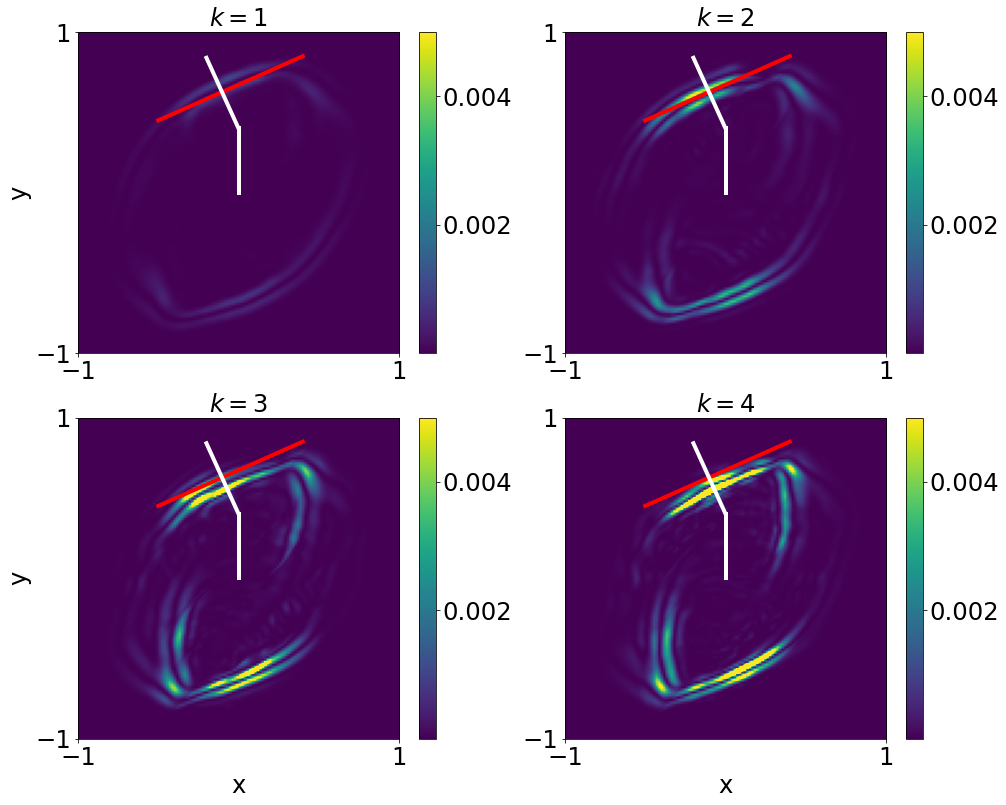

In [23]:
tj = 4
fig1 = plt.figure(figsize=(16,13))
ax1 = fig1.add_subplot(2,2,1)
pos1 = ax1.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj,0],utnn1[:,:,tj,0],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax1.set_title(r'$k=1$')
plt.xticks([-1,1])
plt.yticks([-1,1])
ax1.set_ylabel('y')
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.004])

ax2 = fig1.add_subplot(2,2,2)
ax2.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj,1],utnn1[:,:,tj,1],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax2.set_title(r'$k=2$')
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.004])

ax3 = fig1.add_subplot(2,2,3)
ax3.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj,2],utnn1[:,:,tj,2],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax3.set_title(r'$k=3$')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.004])

ax4 = fig1.add_subplot(2,2,4)
ax4.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj,3],utnn1[:,:,tj,3],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax4.set_title(r'$k=4$')
ax4.set_xlabel('x')
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.004])